In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")

from tools.feature_extractors.geo_extractor import GeoExtractor
from tools.feature_extractors.datetime_extractor import DatetimeExtractor
from tools.feature_extractors.weather_extractor import WeatherExtractor
from tools.feature_extractors.osm_extractor import OsmExtractor

## Load Dataset

In [2]:
data = pd.read_csv("../data/train.zip")
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])

test = pd.read_csv("../data/test.zip")
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

basic_features = ["vendor_id", "passenger_count", 
                  "pickup_longitude",  "pickup_latitude", 
                  "dropoff_longitude", "dropoff_latitude",]

## Clean Data

In [3]:
data = data[data["trip_duration"] <= 5 * 60 * 60]
data = data[data['pickup_longitude'] <= -73.75]
data = data[data['pickup_longitude'] >= -74.03]
data = data[data['pickup_latitude'] <= 40.85]
data = data[data['pickup_latitude'] >= 40.63]
data = data[data['dropoff_longitude'] <= -73.75]
data = data[data['dropoff_longitude'] >= -74.03]
data = data[data['dropoff_latitude'] <= 40.85]
data = data[data['dropoff_latitude'] >= 40.63]

## Extract Date/Time Features

In [4]:
data = DatetimeExtractor().extract_features(data)
test = DatetimeExtractor().extract_features(test)

dt_features = [col for col in data.columns if col.startswith("dt")]
print(dt_features)

['dt_holiday', 'dt_weekday', 'dt_weekend', 'dt_hour', 'dt_week_hour', 'dt_day_minutes', 'dt_total_minutes']


## Geo Features 

In [5]:
data = GeoExtractor().extract_features(data)
test = GeoExtractor().extract_features(test)

geo_features = [col for col in data.columns if col.startswith("geo")]
print(geo_features)

['geo_direction', 'geo_haversine']


## Weather Features

In [6]:
data = WeatherExtractor().extract_features(data)
test = WeatherExtractor().extract_features(test)

weather_features = [col for col in data.columns if col.startswith("weather")]
print(weather_features)

['weather_t', 'weather_po', 'weather_p', 'weather_pa', 'weather_u', 'weather_dd', 'weather_ff', 'weather_ff10', 'weather_ff3', 'weather_n', 'weather_ww', 'weather_w1', 'weather_w2', 'weather_tn', 'weather_tx', 'weather_cl', 'weather_nh', 'weather_h', 'weather_cm', 'weather_ch', 'weather_vv', 'weather_td', 'weather_rrr', 'weather_tr', 'weather_e', 'weather_tg', "weather_e'", 'weather_sss']


## Open Street Maps Features

In [7]:
data = OsmExtractor(osm_dataset="../data/train_osm.csv").extract_features(data)
test = OsmExtractor(osm_dataset="../data/test_osm.csv").extract_features(test)

osm_features = [col for col in data.columns if col.startswith("osm")]

1458644it [01:17, 18846.51it/s]
625134it [00:32, 19073.62it/s]


## Modelling Part

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb

train, valid = train_test_split(data)

y_train = train["trip_duration"]
y_valid = valid["trip_duration"]

y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

 ## Median Baseline

In [9]:
y_train_pred = np.ones(y_train.shape) * np.median(y_train)
y_valid_pred = np.ones(y_valid.shape) * np.median(y_train)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Train RMSLE: 0.768
Valid RMSLE: 0.768


## Baseline Model

In [10]:
features = basic_features

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {"rmse"},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'verbose': -1,
}

lgb_train = lgb.Dataset(train[features], y_train_log)
lgb_eval = lgb.Dataset(valid[features], y_valid_log, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_eval),
                verbose_eval=200,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
               )

y_train_pred = np.exp(gbm.predict(train[features], num_iteration=gbm.best_iteration))
y_valid_pred = np.exp(gbm.predict(valid[features], num_iteration=gbm.best_iteration))
y_test_pred = np.exp(gbm.predict(test[features], num_iteration=gbm.best_iteration))

test["trip_duration"] = y_test_pred
test[["id", "trip_duration"]].to_csv("submission.csv.gz", index=False, compression="gzip")

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.45436	valid_1's rmse: 0.456114
[400]	training's rmse: 0.438423	valid_1's rmse: 0.441942
[600]	training's rmse: 0.429687	valid_1's rmse: 0.434624
[800]	training's rmse: 0.423898	valid_1's rmse: 0.43034
[1000]	training's rmse: 0.419557	valid_1's rmse: 0.427203
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.419557	valid_1's rmse: 0.427203
Train RMSLE: 0.416
Valid RMSLE: 0.424


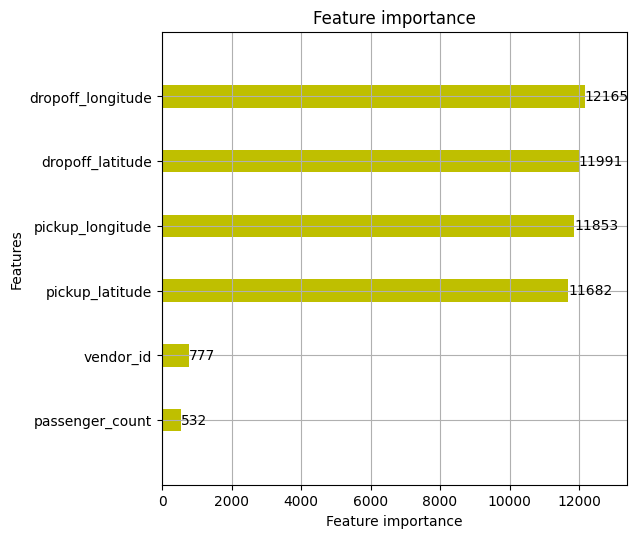

In [11]:
lgb.plot_importance(gbm, max_num_features=15, 
                    figsize=(6, 6), color="y", height=0.35, dpi=100)
plt.show()

## Basic + Datetime + Geo Features

In [12]:
features = basic_features + dt_features + geo_features

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {"rmse"},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'verbose': -1,
}

lgb_train = lgb.Dataset(train[features], y_train_log)
lgb_eval = lgb.Dataset(valid[features], y_valid_log, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_eval),
                verbose_eval=200,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
               )

y_train_pred = np.exp(gbm.predict(train[features], num_iteration=gbm.best_iteration))
y_valid_pred = np.exp(gbm.predict(valid[features], num_iteration=gbm.best_iteration))
y_test_pred = np.exp(gbm.predict(test[features], num_iteration=gbm.best_iteration))

test["trip_duration"] = y_test_pred
test[["id", "trip_duration"]].to_csv("submission.csv.gz", index=False, compression="gzip")

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.353966	valid_1's rmse: 0.359228
[400]	training's rmse: 0.341696	valid_1's rmse: 0.352345
[600]	training's rmse: 0.334469	valid_1's rmse: 0.349141
[800]	training's rmse: 0.328699	valid_1's rmse: 0.346969
[1000]	training's rmse: 0.323583	valid_1's rmse: 0.345191
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.323583	valid_1's rmse: 0.345191
Train RMSLE: 0.321
Valid RMSLE: 0.342


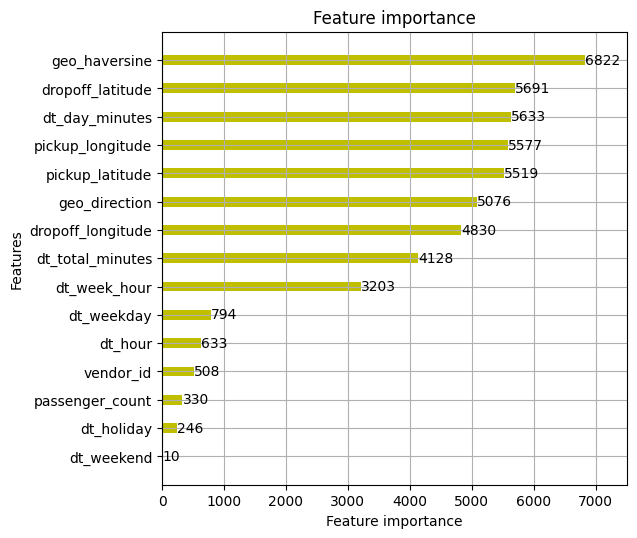

In [13]:
lgb.plot_importance(gbm, max_num_features=15, 
                    figsize=(6, 6), color="y", height=0.35, dpi=100)
plt.show()

## Basic + Datetime + Geo + Weather Features

In [14]:
features = basic_features + dt_features + geo_features + weather_features

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {"rmse"},
    'num_leaves': 200,
    'learning_rate': 0.05,
    'verbose': -1,
}

lgb_train = lgb.Dataset(train[features], y_train_log)
lgb_eval = lgb.Dataset(valid[features], y_valid_log, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_eval),
                verbose_eval=200,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
               )

y_train_pred = np.exp(gbm.predict(train[features], num_iteration=gbm.best_iteration))
y_valid_pred = np.exp(gbm.predict(valid[features], num_iteration=gbm.best_iteration))
y_test_pred = np.exp(gbm.predict(test[features], num_iteration=gbm.best_iteration))

test["trip_duration"] = y_test_pred
test[["id", "trip_duration"]].to_csv("submission.csv.gz", index=False, compression="gzip")

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.326091	valid_1's rmse: 0.348098
[400]	training's rmse: 0.307987	valid_1's rmse: 0.342943
[600]	training's rmse: 0.29733	valid_1's rmse: 0.340357
[800]	training's rmse: 0.288517	valid_1's rmse: 0.338598
[1000]	training's rmse: 0.280814	valid_1's rmse: 0.337415
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.280814	valid_1's rmse: 0.337415
Train RMSLE: 0.279
Valid RMSLE: 0.334


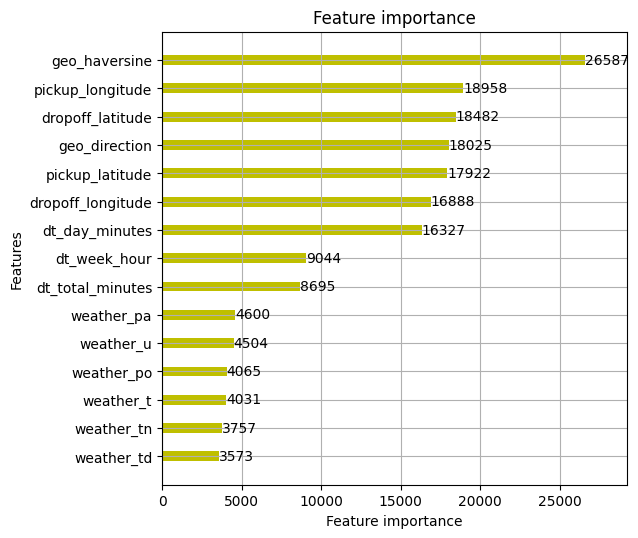

In [15]:
lgb.plot_importance(gbm, max_num_features=15, 
                    figsize=(6, 6), color="y", height=0.35, dpi=100)
plt.show()

## Model with Full Features Set

In [16]:
features = basic_features + dt_features + geo_features + weather_features + osm_features

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {"rmse"},
    'num_leaves': 200,
    'learning_rate': 0.05,
    'verbose': -1,
}

lgb_train = lgb.Dataset(train[features], y_train_log)
lgb_eval = lgb.Dataset(valid[features], y_valid_log, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_eval),
                verbose_eval=200,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
               )

y_train_pred = np.exp(gbm.predict(train[features], num_iteration=gbm.best_iteration))
y_valid_pred = np.exp(gbm.predict(valid[features], num_iteration=gbm.best_iteration))
y_test_pred = np.exp(gbm.predict(test[features], num_iteration=gbm.best_iteration))

test["trip_duration"] = y_test_pred
test[["id", "trip_duration"]].to_csv("submission.csv.gz", index=False, compression="gzip")

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.316782	valid_1's rmse: 0.341008
[400]	training's rmse: 0.297662	valid_1's rmse: 0.336395
[600]	training's rmse: 0.287067	valid_1's rmse: 0.334053
[800]	training's rmse: 0.278998	valid_1's rmse: 0.332667
[1000]	training's rmse: 0.271782	valid_1's rmse: 0.331502
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.271782	valid_1's rmse: 0.331502
Train RMSLE: 0.270
Valid RMSLE: 0.328


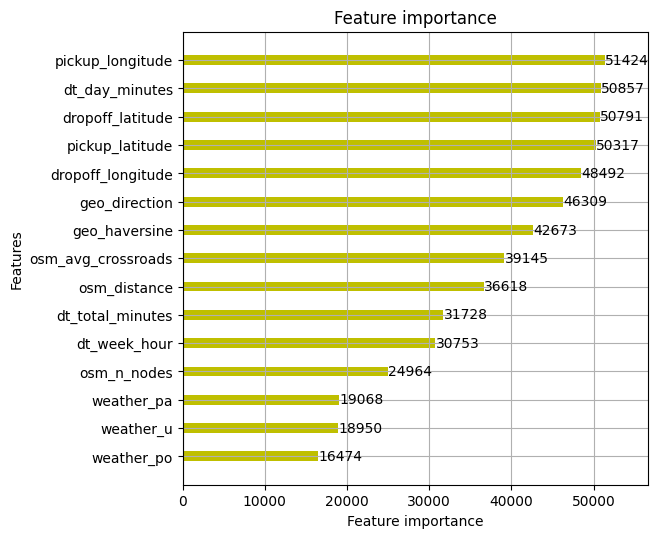

In [19]:
lgb.plot_importance(gbm, max_num_features=15, 
                    figsize=(6, 6), color="y", height=0.35, dpi=100)
plt.show()

## Add more leaves for final submition

In [18]:
features = basic_features + dt_features + geo_features + weather_features + osm_features

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {"rmse"},
    'num_leaves': 700,
    'learning_rate': 0.05,
    'verbose': -1,
}

lgb_train = lgb.Dataset(train[features], y_train_log)
lgb_eval = lgb.Dataset(valid[features], y_valid_log, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_eval),
                verbose_eval=200,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
               )

y_train_pred = np.exp(gbm.predict(train[features], num_iteration=gbm.best_iteration))
y_valid_pred = np.exp(gbm.predict(valid[features], num_iteration=gbm.best_iteration))
y_test_pred = np.exp(gbm.predict(test[features], num_iteration=gbm.best_iteration))

test["trip_duration"] = y_test_pred
test[["id", "trip_duration"]].to_csv("submission.csv.gz", index=False, compression="gzip")

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred))
print(f"Train RMSLE: {rmsle_train:0.3f}")
print(f"Valid RMSLE: {rmsle_valid:0.3f}")

Training until validation scores don't improve for 20 rounds
[200]	training's rmse: 0.280375	valid_1's rmse: 0.333975
[400]	training's rmse: 0.257352	valid_1's rmse: 0.330792
[600]	training's rmse: 0.24198	valid_1's rmse: 0.329371
[800]	training's rmse: 0.229591	valid_1's rmse: 0.328407
[1000]	training's rmse: 0.218478	valid_1's rmse: 0.32796
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.218478	valid_1's rmse: 0.32796
Train RMSLE: 0.218
Valid RMSLE: 0.325
